# **Homework 2: Image segmentation without user input**

## Overview
This homework has two parts.

The first part of this homework is to implement [Grad-CAM](https://arxiv.org/pdf/1610.02391) – a method for producing saliency maps (heatmaps of regions that are most relevant to a model) that uses both activations and gradients of the feature maps of a convolutional layer. Feature maps of deeper convolutional layers represent more high-level features, while preserving rough spatial structure, which makes them a good candidate for explaining a model's output.

The second part of this homework is to use SAM for image segmentation without user input.
SAM [(Segment Anything Model v1)](https://arxiv.org/pdf/2304.02643) is a popular family of open-weight models for image segmentation (based on the vision transformer ViT and CLIP).
The model takes as input an image to be segmented and additionaly bounding boxes, point coordinates etc. clarifying the object of interest to be segmented. It can output many proposed segmentations of many objects on one image. Your task will be to find appropriate point coordinates automatically, so that SAM can be used with just an image input to segment particular objects.

---

## Dataset

You will use a small custom dataset based on [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10), but containing images with one of five objects (circle, square, diamond, triangle, star), with ground-truth segmentations of that object.

---

## GradCAM task

For the first task:
* Read the original [Grad-CAM](https://arxiv.org/pdf/1610.02391) paper.
* Implement it, without using non-standard packages (the only imports allowed are built-ins, torch, torchvision, numpy, scipy, and helpers like cv2, PIL, tqdm, matplotlib).
* The result should be a class named `GradCAM` with methods:
    * `def __init__(model: nn.Module, target_layers=Iterable[nn.Module])`
    * `def __call__(self, image: Tensor, targets: Iterable[int] | None = None) -> np.ndarray` where
        * `image` is an input to `model` (a normalized batch of shape `B,C,H,W`).
        * `targets` is an iterable of target classes that we want to segment; if None is given, use the top class predicted by the model.
        * The result is a numpy array of shape (B, H, W) containing the GradCam heatmap, with `min..max` values rescaled to `0..1` (independently for each image in the batch and each `target_layers`). If more than one `target_layers` was given, return the average of the resulting heatmaps.      
    * Feel free to add optional/default arguments and additional methods.
* Check your implementation by running the code under the `GradCAM results` header.

Tip: you may find it particularly useful to use: [nn.Module.register_full_backward_hook](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook).


## Segmentation task

For the second part, SAM is given as a black-box. You must design a pipeline that takes only an image and outputs a segmentation of the circle/square/diamond/triangle/star shape. The input to SAM should be the image and coordinates of point(s) that are likely to be inside ("foreground") or likely to be outside ("background") of the shape. **The coordinates must be the output of the previous step of the pipeline. They cannot be provided directly by user.**

* Think of a way to find appropriate points. Try two different approaches:
    1. at least one foreground point, without background points.
    2. at least one foreground point and at least one background point.
* Implement both approches as subclasses of `BasicSamPipeline`, overriding the `__call__` method (preserving the signature).
* Evaluate your generated point(s) and report the following metrics:
    * *hit rate*: how often they fall inside the ground-truth mask;
    * *distance*: distance from the center of mass of the ground-truth mask
        (the average coordinate of True pixels in the mask).
* Evaluate your overall pipeline and report the following metric:
    * *Intersection over Union (IoU)* of the predicted and ground-truth masks, averaged over all images in the dataset.


**Important**: This task is not about finding the pipeline with best hyperparameters; we expect an IoU of at least `65%`, but achieving results higher than that will not affect the grade for the assignment.

**Important**: Do not train or fine-tune your own models, only use the ones provided (the classifier and SAM).

---

## Deliverables

On [Moodle](https://moodle.mimuw.edu.pl/mod/assign/view.php?id=159965), submit a .zip archive with:

1. **Notebook** (`.ipynb`):
    * It should contain:
        * The GradCAM implementation.
        * The two `BasicSamPipeline` subclasses.
        * Evaluations with computations of all reported metrics.
    * It should be possible to execute the whole notebook start-to-end without human intervention.
    * Such an execution should take less than 30 minutes on a Colab GPU.
    * Do not modify (but *do* execute) cells under headers marked as `[do not modify]`. If you wish to extend them (e.g. to check more GradCAM results), you may do so **under a new header**.

2. **Report (1-2 pages, PDF)** including:
   * An examplary visualization of the output of the Grad-CAM
   * A concise description of each approach for the SAM pipelines (1-3 sentences each).
   * A presentation of all metrics.
   * Discussion (up to 5 sentences) on potential areas for improvements.

3. **README.md**:
   * Link to Colab version of the notebook for fast replication.



## Grading

1. Implementation correctness of Grad-CAM:  30%
2. Implementation correctness of the multistage pipeline and evaluations: 50%
3. Report & analysis: 20%

Please take care of readability, clear structure in particular (headers in notebooks, modular code).
This will be considered within each grading component.



# 0. Preliminaries

## Imports

In [1]:
!pip install torch torchvision matplotlib opencv-python-headless numpy segment-anything

In [2]:
import os
import random
from collections.abc import Callable, Iterable
from pathlib import Path
from typing import Any, Final, Literal, TypedDict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import scipy.ndimage
import torch
import torch.nn.functional as F
import torchvision.models
from torch import Tensor, nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from tqdm import tqdm

In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

## Dataset [do not modify]

CIFAR-10 download takes 170 MiB.

In [4]:
%%bash --no-raise-error
mkdir -p data/
wget -nc -q -O data/synthetic_shapes.zip https://www.mimuw.edu.pl/~mwrochna/upload/synthetic_shapes.zip
unzip -d data/ data/synthetic_shapes.zip &> /dev/null

In [5]:
class SyntheticData[T](Dataset):
    """A small synthetic segmentation dataset.

    It is a sequence dataset of 5000 tuples (image, class, mask), where:
    - image: before transformation, an RGB PIL Image.
    - class: int 0..4, the label index.
    - mask:  numpy array of dtype=bool, shape (H, W), same size as image.
    """

    CLASSES: Final[tuple[str, ...]] = ("circle", "square", "triangle", "star", "diamond")

    def __init__(
        self,
        path: Path,
        split: Literal["train", "val", "test"],
        transform: Callable[[PIL.Image.Image], T],
    ) -> None:
        self.path = path
        self.transform = transform
        self.split = split

        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.CLASSES)}

        images = sorted((self.path / "images" / self.split).glob("*.png"))
        masks = sorted((self.path / "masks" / self.split).glob("*.png"))
        labels = sorted((self.path / "labels" / self.split).glob("*.txt"))

        assert images, f"No images found in {self.path / 'images' / self.split}"
        assert len(images) == len(masks) == len(labels), (
            "Number of images, masks, and labels must be the same"
        )
        assert [p.stem for p in images] == [p.stem for p in masks] == [p.stem for p in labels], (
            "Image/mask/label filename mismatch."
        )
        self.image_names = [p.stem for p in images]

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, idx) -> tuple[T, int, np.ndarray]:
        name = self.image_names[idx]
        img_path = self.path / "images" / self.split / f"{name}.png"
        mask_path = self.path / "masks" / self.split / f"{name}.png"
        label_path = self.path / "labels" / self.split / f"{name}.txt"

        img = PIL.Image.open(img_path).convert("RGB")
        mask = np.array(PIL.Image.open(mask_path), dtype=bool)
        label = self.class_to_idx[label_path.read_text().strip()]

        img_transformed: T = self.transform(img)

        return img_transformed, label, mask


def show_image_row(
    image_dict: dict[str, PIL.Image.Image | np.ndarray | Tensor], size: float = 3.0
) -> None:
    n = len(image_dict)
    _, axs = plt.subplots(1, n, figsize=(size * n, size), constrained_layout=True, squeeze=True)
    if n == 1:
        axs = [axs]
    for ax, (title, img) in zip(axs, image_dict.items(), strict=True):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.show()

train dataset size: 3500
val dataset size: 1000
test dataset size: 500


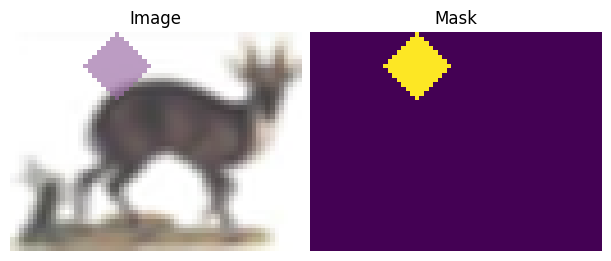

Label: 4 (diamond)
train dataset size: 3500
val dataset size: 1000
test dataset size: 500


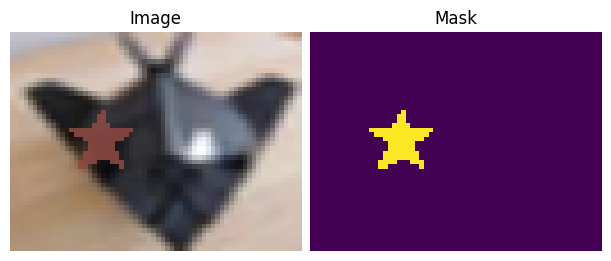

Label: 3 (star)


In [6]:
dataset_path = Path("./data/synthetic_shapes")


def example_from_dataset(idx: int = 3):
    for split in ("train", "val", "test"):
        dataset = SyntheticData(dataset_path, split=split, transform=lambda x: x)
        print(f"{split} dataset size: {len(dataset)}")

    img, label, mask = dataset[idx]
    show_image_row({"Image": img, "Mask": mask})
    print(f"Label: {label} ({SyntheticData.CLASSES[label]})")


example_from_dataset(3)
example_from_dataset(4)

## Training a classifier [do not modify]

In [7]:
def train(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    epochs: int = 5,
    **optimizer_kwargs: Any,
) -> None:
    print(f"🚀 Training CNN for {epochs} epochs...")
    optimizer = optim.AdamW(model.parameters(), **optimizer_kwargs)

    for epoch in range(epochs):
        _train_epoch(model, train_loader, optimizer, desc=f"Epoch {epoch + 1}/{epochs} training  ")
        val_metrics = evaluate(model, val_loader, desc=f"Epoch {epoch + 1}/{epochs} validation")
        print(
            f"Epoch {epoch + 1}/{epochs} — "
            + f"val loss: {val_metrics['loss']:.3f}, val acc: {val_metrics['accuracy']:.1%}"
        )

    test_metrics = evaluate(model, test_loader, desc="Test Evaluation")
    print(
        "✅ Model training complete: "
        + f"Test loss: {test_metrics['loss']:.3f}, test acc: {test_metrics['accuracy']:.1%}"
    )


def _train_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: optim.Optimizer,
    desc: str,
) -> dict[str, float]:
    model.train()
    device = next(model.parameters()).device
    total_loss = 0
    total_correct = 0
    total_samples = 0
    progress_bar = tqdm(dataloader, desc=desc)
    for imgs, labels, _ in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.shape[0]
        total_correct += (predicted == labels).sum().item()

        progress_bar.set_postfix(
            train_loss=f"{total_loss / (total_samples / labels.shape[0]):.3f}",
            train_acc=f"{total_correct / total_samples:.1%}",
        )

    return {"loss": total_loss / len(dataloader), "accuracy": total_correct / total_samples}


def evaluate(
    model: nn.Module, dataloader: torch.utils.data.DataLoader, desc: str
) -> dict[str, float]:
    model.eval()
    device = next(model.parameters()).device
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for imgs, labels, _mask in tqdm(dataloader, desc=desc):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, dim=1)
            total_samples += labels.shape[0]
            total_correct += (predicted == labels).sum().item()

    return {"loss": total_loss / len(dataloader), "accuracy": total_correct / total_samples}


class DataloaderArgs(TypedDict, total=False):
    batch_size: int
    shuffle: bool
    num_workers: int
    pin_memory: bool

In [8]:
device = torch.accelerator.current_accelerator(check_available=True) or torch.device("cpu")
use_accel = device != torch.device("cpu")
print(use_accel, device)

True cuda


In [9]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
inverse_transform = v2.Compose(
    [
        v2.Normalize(
            [-m / s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD, strict=True)],
            [1 / s for s in IMAGENET_STD],
        ),
        v2.ToPILImage(),
    ]
)

train_dataset = SyntheticData(dataset_path, transform=transform, split="train")
val_dataset = SyntheticData(dataset_path, transform=transform, split="val")
test_dataset = SyntheticData(dataset_path, transform=transform, split="test")

train_kwargs: DataloaderArgs = {
    "batch_size": 128,
    "num_workers": 2,
    "shuffle": True,
    "pin_memory": use_accel,
}
val_kwargs: DataloaderArgs = {"batch_size": 500, "num_workers": 2, "pin_memory": use_accel}
test_kwargs: DataloaderArgs = val_kwargs

train_loader = DataLoader(train_dataset, **train_kwargs)
val_loader = DataLoader(val_dataset, **val_kwargs)
test_loader = DataLoader(test_dataset, **test_kwargs)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print("✅ DataLoaders created for train, validation, and test sets.")

Train dataset size: 3500
Validation dataset size: 1000
Test dataset size: 500
✅ DataLoaders created for train, validation, and test sets.


In [10]:
checkpoint_path = Path("./model_checkpoint.pth")

model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(SyntheticData.CLASSES))
model = model.to(device)

if not checkpoint_path.exists():
    train(model, train_loader, val_loader, test_loader, epochs=5, lr=2e-3, weight_decay=0.05)
    torch.save(model.state_dict(), checkpoint_path)
else:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
    metrics = evaluate(model, test_loader, desc="Test Evaluation")
    print()
    print(
        "✅ Model loaded from checkpoint: "
        + f"Test loss: {metrics['loss']:.3f}, test acc: {metrics['accuracy']:.1%}"
    )

Test Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


✅ Model loaded from checkpoint: Test loss: 0.315, test acc: 90.0%


# 1. GradCAM

## GradCAM implementation (add your code)

In [11]:
class GradCAM:
    """
    Pure PyTorch implementation of Grad-CAM (Gradient-weighted Class Activation Mapping).

    Grad-CAM highlights the important regions in the input that contribute most to
    the model's prediction for a given target class. It uses both activations and
    gradients of the feature maps from a convolutional layer.

    Usage:
        grad_cam = GradCAM(model=model, target_layers=[layer1, layer2])
        grayscale_cam = grad_cam(input_tensor, targets=[class_id])

    Args:
        model (nn.Module): The neural network to compute Grad-CAM for.
        target_layers (Iterable[nn.Module]): The convolutional layers to target
            for Grad-CAM computation. Feature maps and their gradients from these
            layers will be used.
    """

    def __init__(self, model: nn.Module, target_layers: Iterable[nn.Module]) -> None:
        self.model = model
        self.target_layers = target_layers
        # List to store gradients during backward pass, though not directly used in final CAM computation here,
        # hooks handle the access to gradients directly from the layers.
        self.gradients = []

    def __call__(self, input_tensor: Tensor, targets: Iterable[int] | None = None) -> np.ndarray:
        """
        Computes Grad-CAM heatmaps for the input tensor.

        Args:
            input_tensor (Tensor): Input tensor of shape (B, C, H, W) or (C, H, W).
                                   It will be unsqueezed if it's a single image.
            targets (Iterable[int] | None): List of target class indices for which to compute
                Grad-CAM. If None, the class with the highest predicted score will be used.

        Returns:
            np.ndarray: Grad-CAM heatmaps of shape (B, H, W). Values are normalized to the range [0, 1].
                        If multiple `target_layers` are provided, the heatmaps are averaged.
        """

        # Add batch dimension if input is a single image
        if input_tensor.dim() == 3:
            input_tensor = input_tensor.unsqueeze(0)

        # Ensure that input_tensor requires gradients for backpropagation
        # This is crucial for Grad-CAM to work as it relies on gradients w.r.t. feature maps
        input_tensor.requires_grad_(True)

        B, C, H, W = input_tensor.shape
        # Placeholder for collected heatmaps from different layers
        layers_heatmaps = []

        # Define hooks to capture activations and gradients
        # The forward hook captures the output feature maps (activations)
        def save_output_hook(module, input, output):
            module.saved_output = output.detach()  # Detach to prevent modifying the computational graph

        # The backward hook captures the gradients flowing back to the feature maps
        def save_grad_hook(module, grad_input, grad_output):
            # grad_output[0] contains the gradient w.r.t. the output of the module
            module.saved_grad = grad_output[0]

        handles = []
        try:
            # Register hooks for each target layer
            for layer in self.target_layers:
                handles.append(layer.register_forward_hook(save_output_hook))
                handles.append(layer.register_backward_hook(save_grad_hook))

            # Set model to evaluation mode
            self.model.eval()

            # Forward pass: compute model output
            output = self.model(input_tensor)

            # Determine the target class(es) for which to compute Grad-CAM
            if targets is None:
                # If no specific target is given, use the class with the highest predicted score
                targets = output.argmax(dim=1)

            # Zero gradients before backward pass
            self.model.zero_grad()

            # Compute the sum of scores for the target classes
            # This sum becomes the 'loss' for backpropagation to calculate gradients w.r.t. target classes
            loss = output[:, targets].sum()

            # Backward pass: compute gradients
            loss.backward()

            # Iterate through target layers to compute Grad-CAM
            for layer in self.target_layers:
                # Retrieve saved activations and gradients from the hooks
                activations = layer.saved_output  # A^k in the Grad-CAM paper
                gradients = layer.saved_grad      # ∂Y^c/∂A^k in the Grad-CAM paper

                # Compute the neuron importance weights (alpha_k)
                # Global average pooling of gradients: α_k^c = (1/Z) Σ_i Σ_j ∂Y^c / ∂A_{ij}^k
                weights = gradients.mean(dim=(2, 3), keepdim=True)  # Shape: (B, C_k, 1, 1)

                # Compute the weighted activation map (L_Grad-CAM^c)
                # Sum of (weights * activations) across channels, then ReLU
                # L_Grad-CAM^c = ReLU(Σ_k α_k^c A^k)
                cam = F.relu((weights * activations).sum(dim=1, keepdim=True))

                # Upsample the CAM to the original image size
                cam = F.interpolate(cam, size=(H, W), mode='bilinear', align_corners=False)

                # Normalize the heatmap to the range [0, 1] for visualization
                cam = cam.squeeze(1).detach().cpu().numpy()  # Convert to numpy array (B, H, W)
                # Normalize independently for each image in the batch
                cam_min = cam.min(axis=(1, 2), keepdims=True)
                cam_max = cam.max(axis=(1, 2), keepdims=True)
                cam = (cam - cam_min) / (cam_max - cam_min + 1e-8) # Add epsilon to prevent division by zero
                layers_heatmaps.append(cam)

            # Average heatmaps from all target layers if multiple were specified
            final_heatmaps = np.mean(np.array(layers_heatmaps), axis=0)

        finally:
            # Always remove hooks to prevent memory leaks and unintended behavior
            for handle in handles:
                handle.remove()

        # Clear model gradients after computation
        self.model.zero_grad()
        return final_heatmaps

## GradCAM results [do not modify]

In [12]:
if type(model).__name__ == "ResNet":
    target_layers = [model.layer2[-1]]
else:
    target_layers = [
        model.get_submodule("features.2.0"),
        model.get_submodule("features.3.0"),
        model.get_submodule("features.4.0"),
    ]

In [13]:
def heatmap_to_rgb_image(
    heatmap: np.ndarray, min: float | None = None, max: float | None = None
) -> PIL.Image.Image:
    """
    Converts a single-channel heatmap to an RGB pillow image using a colormap.

    Args:
    - heatmap: shape (H, W), will be normalized by mapping min..max to 0..1.
    - min: minimum value for normalization, defaults to heatmap.min().
    - max: maximum value for normalization, defaults to heatmap.max()
    """
    heatmap = heatmap.astype(np.float32)
    if min is None:
        min = heatmap.min()
    if max is None:
        max = heatmap.max()
    heatmap = (heatmap - min) / (max - min + 1e-8)
    heatmap_uint8 = (np.clip(heatmap, 0.0, 1.0) * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    return PIL.Image.fromarray(heatmap_color)

/home/miki/UniProjects/Gsn/Image_segmentation_without_user_input/venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


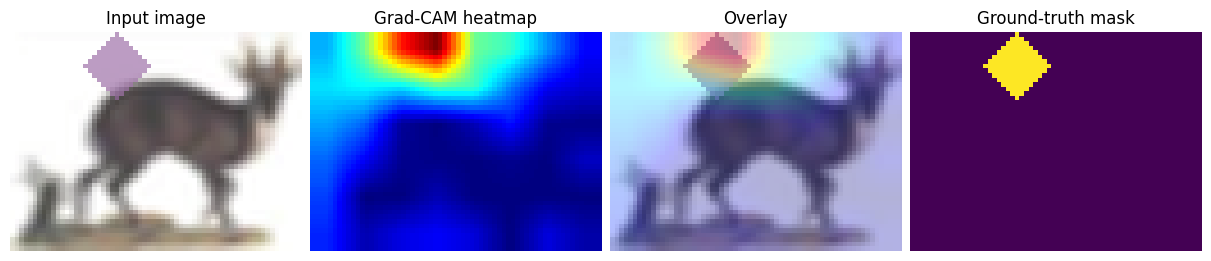

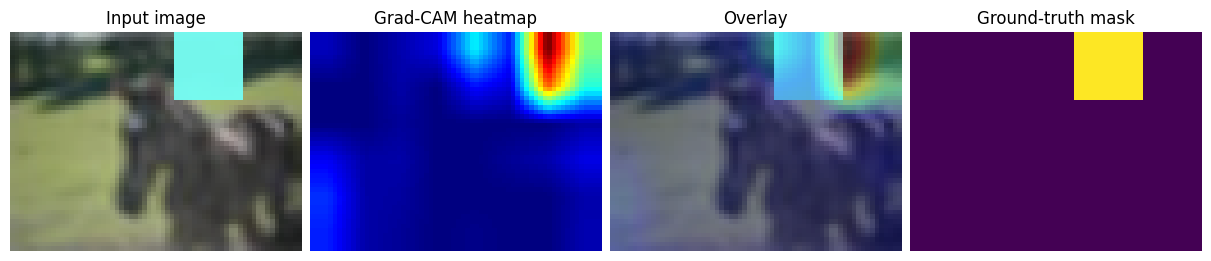

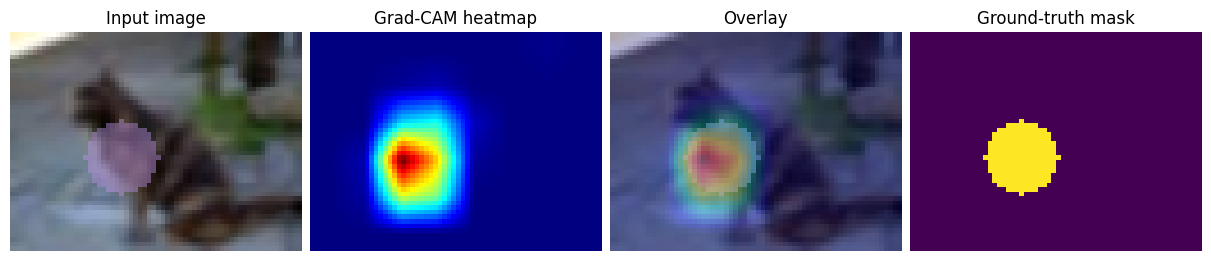

In [14]:
def example_gradcam():
    grad_cam = GradCAM(model=model, target_layers=target_layers)

    for test_idx in [3, 10, 42]:
        img, label, mask = test_dataset[test_idx]

        cam = grad_cam(img.unsqueeze(0).to(device), targets=[label])
        heatmap_img = heatmap_to_rgb_image(cam.squeeze(0), 0, 1)

        show_image_row(
            {
                "Input image": inverse_transform(img),
                "Grad-CAM heatmap": heatmap_img,
                "Overlay": PIL.Image.blend(inverse_transform(img), heatmap_img, alpha=0.3),
                "Ground-truth mask": mask,
            }
        )


example_gradcam()

##Functionality tests

In [15]:
def example_gradcam2(model: nn.Module, target_layers: Iterable[nn.Module],targets: Iterable[int], batch_size: int = 1,):
    grad_cam = GradCAM(model=model, target_layers=target_layers)

    loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    images, labels, masks = next(iter(loader))
    images = images.to(device)
    heatmaps = grad_cam(images, targets)

    for cam, img, mask in zip(heatmaps, images, masks):
        heatmap_img = heatmap_to_rgb_image(cam, 0, 1)

        show_image_row(
            {
                "Input image": inverse_transform(img),
                "Grad-CAM heatmap": heatmap_img,
                "Overlay": PIL.Image.blend(inverse_transform(img), heatmap_img, alpha=0.3),
                "Ground-truth mask": mask,
            }
        )


###1. No target labels

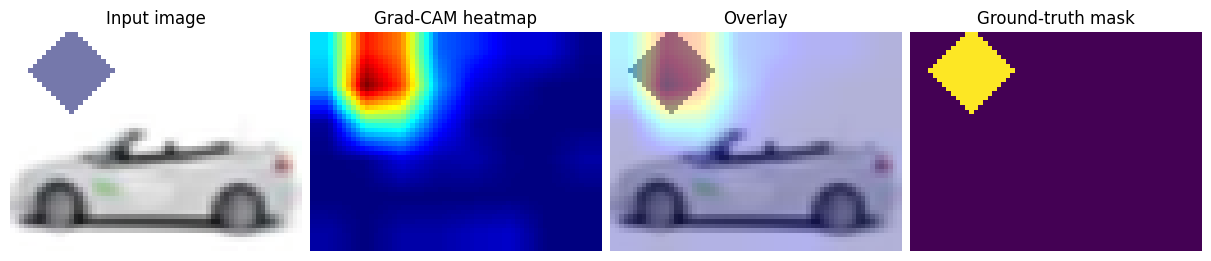

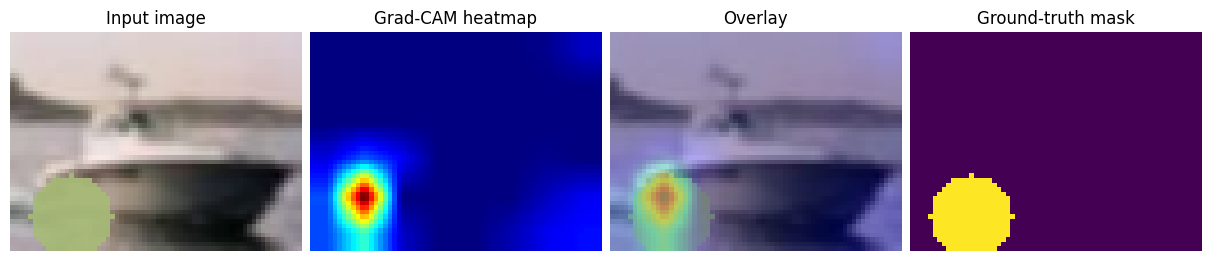

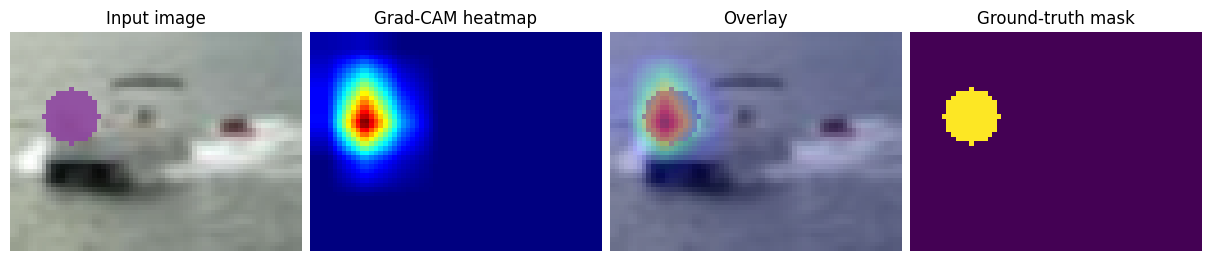

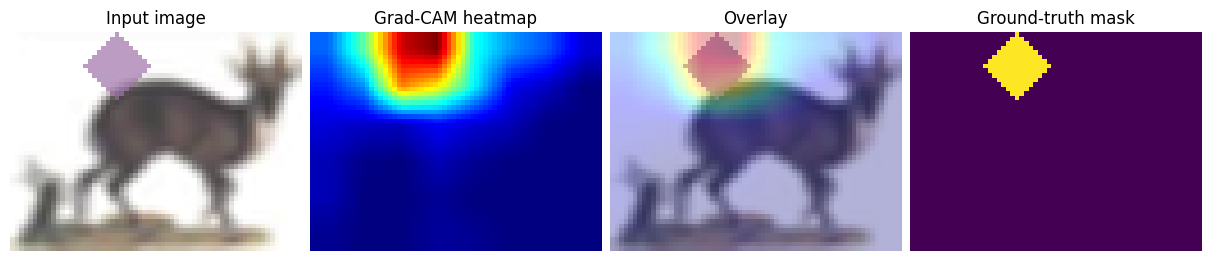

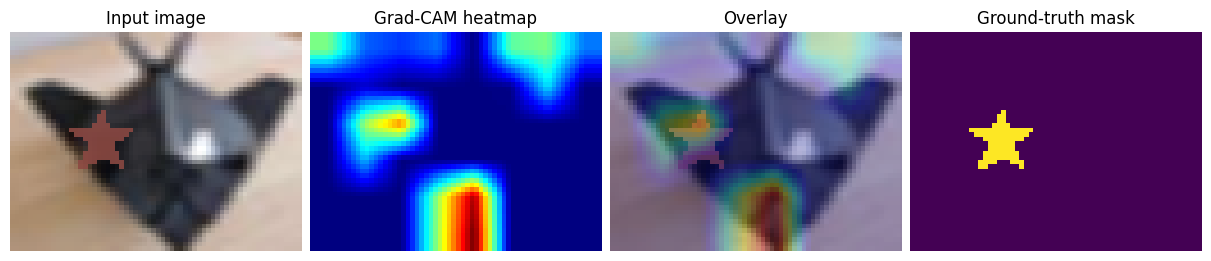

In [16]:
example_gradcam2(model=model, target_layers=target_layers, targets=None, batch_size=5)

###2. Multiple target layers

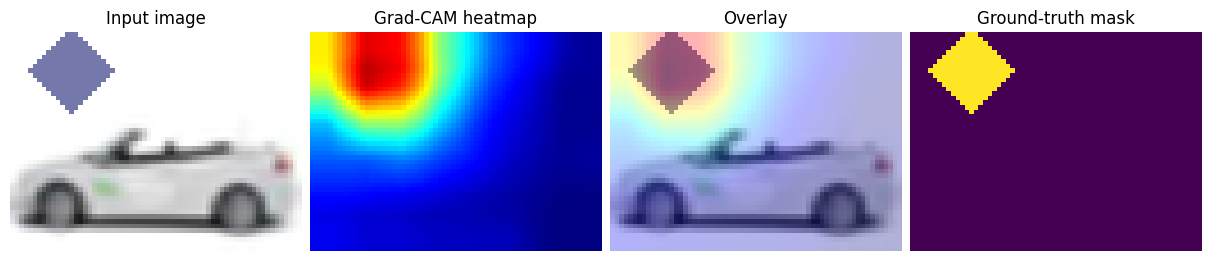

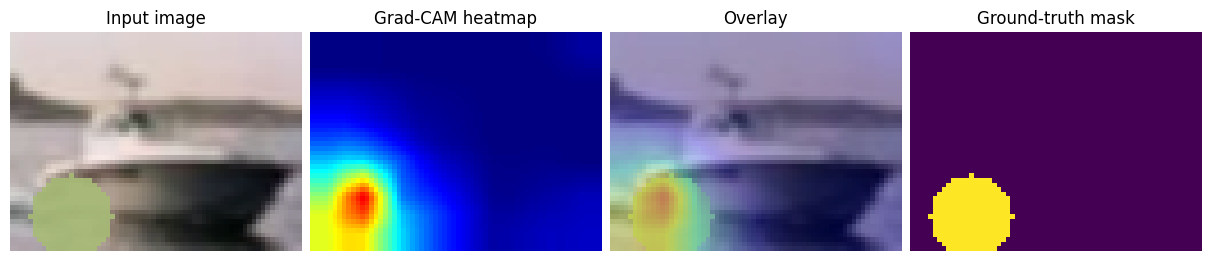

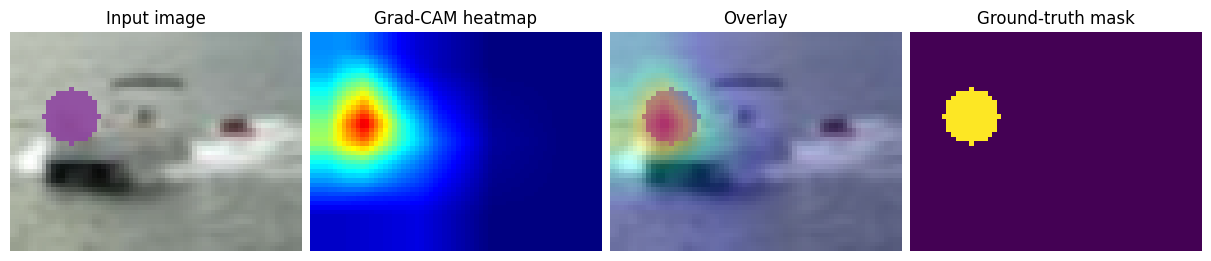

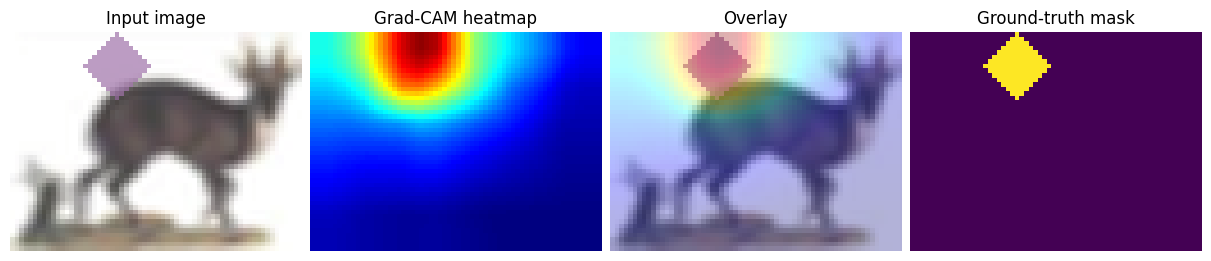

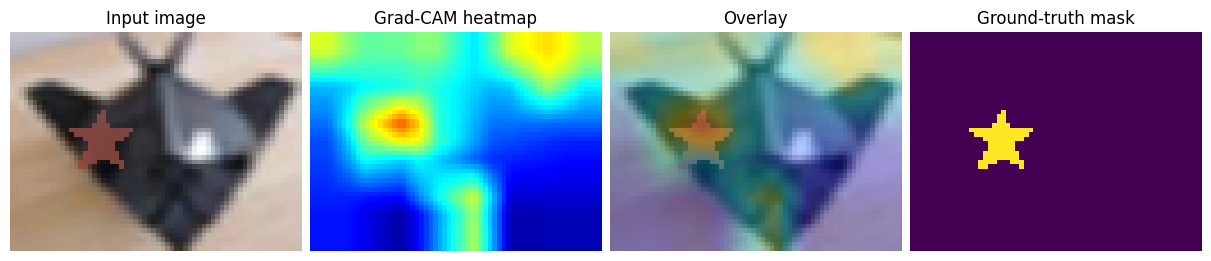

In [17]:
target_layers = [model.layer3[-1], model.layer2[-1]]
example_gradcam2(model=model, target_layers=target_layers, targets=None, batch_size=5)

###3. Multiple classes


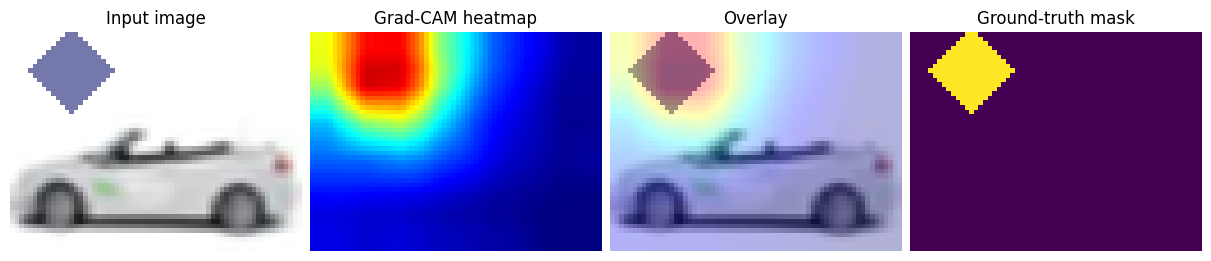

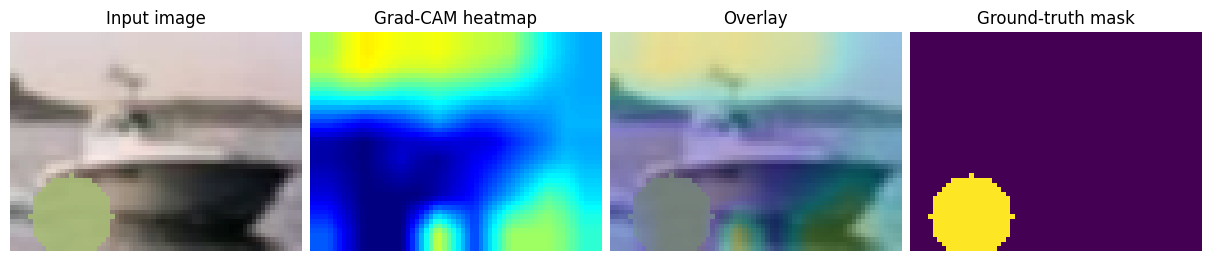

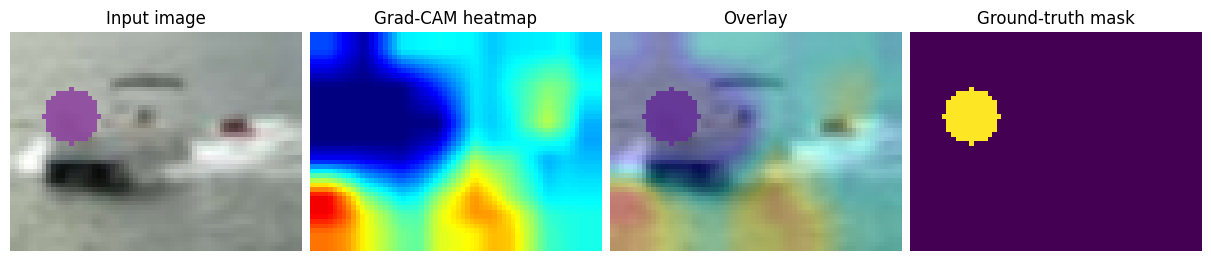

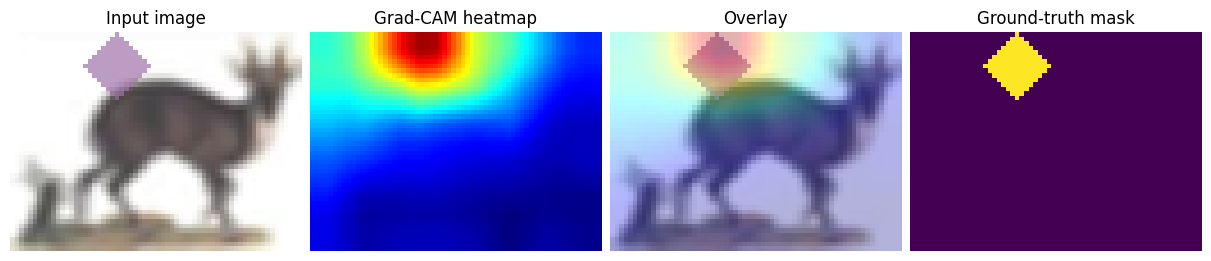

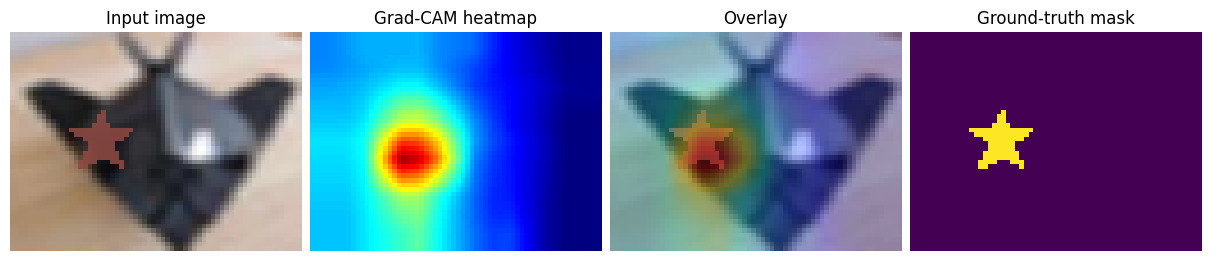

In [18]:
targets = [3, 4] #Star and Diamond
example_gradcam2(model=model, target_layers=target_layers, targets=targets, batch_size=5)

# 2. Segment Anything Model



## Basic usage [do not modify]
The checkpoint takes 360 MB.

In [19]:
%pip install segment-anything
!wget -nc -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

Note: you may need to restart the kernel to use updated packages.


In [20]:
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

sam_checkpoint_path = Path("./sam_vit_b_01ec64.pth")
assert sam_checkpoint_path.exists(), "SAM checkpoint not found."

# We'll use a single global SAM model to avoid reloading it to memory multiple times.
sam_model = sam_model_registry["vit_b"](checkpoint=sam_checkpoint_path)
sam_model.to(device)
sam_predictor = SamPredictor(sam_model)

In [21]:
class BasicSamPipeline:
    def __call__(self, images: Tensor) -> Tensor:
        """
        Input: normalized images, shape (B, C=3, H, W).
        Output: masks tensor of shape (B, H, W), dtype=bool.
        """
        B, C, H, W = images.shape
        # The basic pipeline always uses a single center point for each image.
        point_coords = np.array([[(W // 2, H // 2)] for _ in range(B)])

        # The basic pipeline always uses a single foreground point, no background points.
        point_labels = np.array([[1] for _ in range(B)], dtype=np.int64)

        return self.segment(images, point_coords, point_labels)

    def segment(
        self, images: Tensor, point_coords: np.ndarray, point_labels: np.ndarray
    ) -> Tensor:
        """
        Args:
        - images: normalized images, shape (B, C=3, H, W).
        - point_coords: point coordinates within each image, shape (B, num_points, 2), format (x,y).
            Note the format is not (h,w)=(y,x), but (x,y)!
        - point_labels: point labels, shape (B, num_points), dtype int64.
            Label 1 is foreground (should be in mask), 0 is background (shouldn't be in mask).

        Returns: segmentation masks, shape (B, H, W), dtype=bool.
        """
        B, C, H, W = images.shape
        assert C == 3, f"Expected images.shape=(B, C=3, H, W), got: {images.shape}"
        num_points = point_coords.shape[1]
        assert point_coords.shape == (B, num_points, 2), f"Expected point_coords.shape=({B=}, num_points, 2), got: {point_coords.shape}"
        assert point_labels.shape == (B, num_points), f"Expected point_labels.shape=({B=}, num_points), got: {point_labels.shape}"

        results = list[Tensor]()
        for image, pt_coords, pt_labels in zip(images, point_coords, point_labels, strict=True):
            sam_predictor.set_image(np.array(inverse_transform(image)))
            masks, scores, _logits = sam_predictor.predict(
                point_coords=pt_coords, point_labels=pt_labels, multimask_output=True
            )
            best_mask = masks[np.argmax(scores)]
            results.append(torch.tensor(best_mask, dtype=torch.bool))
        return torch.stack(results)

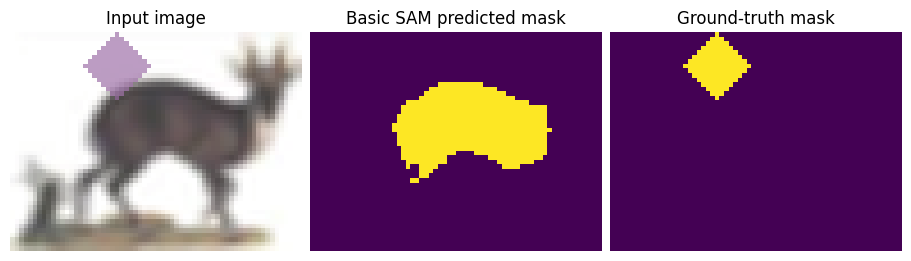

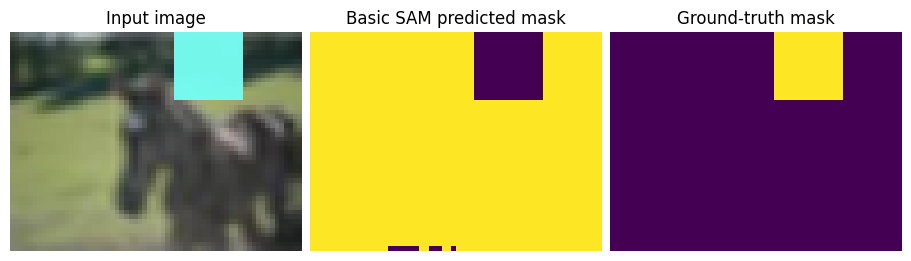

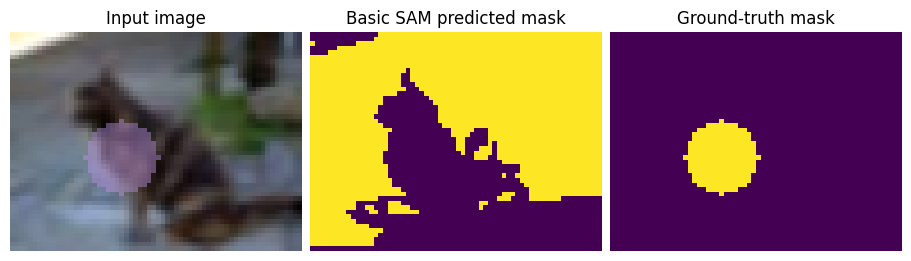

In [22]:
def example_sam():
    indices = [3, 10, 42]
    images, labels, gt_masks = next(iter(test_loader))
    images, labels, gt_masks = images[indices], labels[indices], gt_masks[indices]

    basic_pipeline = BasicSamPipeline()

    results = basic_pipeline(images).cpu()

    for image, result, gt_mask in zip(images, results, gt_masks, strict=True):
        show_image_row(
            {
                "Input image": inverse_transform(image),
                "Basic SAM predicted mask": result,
                "Ground-truth mask": gt_mask,
            }
        )

images, labels, gt_masks = next(iter(test_loader))
example_sam()

## Pipeline implementation and evaluation (add your code)

In [23]:
sam_eval_loader = DataLoader(test_dataset, batch_size=5, num_workers=0, pin_memory=use_accel)

Abstarct custom pipeline class

In [24]:
from abc import abstractmethod, ABC
from typing import List, Tuple # Added this import

class CustomPipeline(BasicSamPipeline, ABC):

    @abstractmethod
    def points(self, images: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Must be implemented in subclasses.
        Should return (point_coords, point_labels).
        """
        pass

### Evaluation Metrics and Tests

*Metrics per Batch*
* Evaluating generated point(s) and reporting the following metrics:
    * *hit rate*: how often they fall inside the ground-truth mask;
    * *distance*: distance from the center of mass of the ground-truth mask
        (the average coordinate of True pixels in the mask).
* Evaluating my overall pipeline and reporting the following metric:
    * *Intersection over Union (IoU)* of the predicted

In [25]:
def hit_rate(gt_mask: Tensor, pr_mask: Tensor) -> float:
    """
    Compute hit rate between ground-truth and predicted masks.

    Hit rate = TP / (TP + FP)

    Where:
    - TP = true positives  = predicted foreground that is actually foreground
    - FP = false positives = predicted foreground that is actually background

    Args:
        gt_mask (Tensor): Ground-truth mask of shape (H, W) or (1, H, W).
        pr_mask (Tensor): Predicted mask of shape (H, W) or (1, H, W).

    Returns:
        float: Hit rate in [0, 1]. Returns 0.0 if denominator is zero.
    """
    gt = gt_mask.bool()
    pr = pr_mask.bool()

    # Squeeze batch/channel dimensions if provided
    if gt.ndim == 2:
        gt = gt.unsqueeze(0)
        pr = pr.unsqueeze(0)

    # True positives
    hit = (gt & pr).sum(dim=(1,2))

    # False positives
    miss = (~gt & pr).sum(dim=(1,2))

    denom = hit + miss
    return torch.mean(hit / (denom)).item()


def distance(gt_masks: Tensor, pr_masks: Tensor) -> float:
    """
    Compute average Euclidean distance from predicted foreground pixels
    to the centroid of the ground-truth foreground region.

    Useful to measure spatial deviation of predicted masks.

    Args:
        gt_mask (Tensor): Ground truth mask of shape (H, W) or (1, H, W).
        pr_mask (Tensor): Predicted mask of shape (H, W) or (1, H, W).

    Returns:
        float: Mean distance. Returns NaN if either mask has no foreground pixels.
    """
    gt = gt_masks.bool()
    pr = pr_masks.bool()

    # Squeeze batch/channel dimensions if provided
    if gt.ndim == 2:
        gt = gt.unsqueeze(0)
        pr = pr.unsqueeze(0)

    # Get ground truth foreground coordinates
    sum = 0
    for g,p in zip(gt,pr):
      g_coords = g.nonzero(as_tuple=False).float()

      # Compute centroid
      centroid = g_coords.mean(dim=0)

      # Get predicted foreground coordinates
      p_coords = p.nonzero(as_tuple=False).float()

      # Compute mean Euclidean distance
      sum  += (torch.sqrt(((p_coords - centroid) ** 2).sum(dim=1))).mean(dim=0)
    return sum/len(gt)


def IoU(gt_masks: Tensor, pr_masks: Tensor) -> float:
    """
    Compute the Intersection-over-Union (IoU) between ground-truth and predicted masks.

    IoU = intersection / union

    Works for single masks (H, W) or batched masks (B, H, W).

    Args:
        gt_masks (Tensor): Ground-truth mask of shape (H, W) or (B, H, W).
        pr_masks (Tensor): Predicted mask of shape (H, W) or (B, H, W).

    Returns:
        float: Mean IoU across the batch.
    """
    gt = gt_masks.bool()
    pr = pr_masks.bool()

    # Expand single image to batch dimension
    if gt.ndim == 2:
        gt = gt.unsqueeze(0)
        pr = pr.unsqueeze(0)

    intersections = (gt & pr).sum(dim=(1,2)).float()   # (B,)
    unions = (gt | pr).sum(dim=(1,2)).float()          # (B,)

    # Avoid division by zero
    eps = 1e-6
    ious = intersections / (unions + eps)

    return ious.mean().item()


### Testing function:
  1. Visualizers for seeing what points pixel has chosen and what was the prediction.
  2. Function for testing pipeline's performance

In [26]:
def get_hints_mask(
    point_cords: np.ndarray,
    point_labels: np.ndarray,
    H: int,
    W: int,
) -> Tensor:
    """
    Create a color-coded visualization mask for SAM point prompts.

    Foreground points (label = 1) are shown in red,
    background points (label = 0) are shown in blue.

    Args:
        point_cords (np.ndarray):
            Array of point coordinates with shape (N, 2) as (x, y).
        point_labels (np.ndarray):
            Array of point labels with shape (N,).
        H (int):
            Height of the output mask.
        W (int):
            Width of the output mask.

    Returns:
        Tensor:
            RGB mask tensor of shape (H, W, 3).
    """

    # Initialize empty RGB mask
    mask = torch.zeros((H, W, 3), dtype=torch.float32, device=images.device)

    # Mark points according to their label
    for cord, label in zip(point_cords, point_labels):
        x, y = cord
        if label == 1:
            mask[y, x, 0] = 1.0  # foreground → red
        else:
            mask[y, x, 2] = 1.0  # background → blue

    return mask


In [27]:
def visual_test(pipeline: CustomPipeline):
    """
    Visually evaluate a SAM-based segmentation pipeline on selected test samples.

    Args:
        pipeline (CustomPipeline):
            A SAM-based segmentation pipeline providing both `__call__`
            and `points` methods.
    """

    # =====================
    #  SAMPLE SELECTION
    # =====================
    indices = [3, 10, 42]

    # Fetch a single batch from the test loader
    images, labels, gt_masks = next(iter(test_loader))

    # Select only the samples of interest
    images = images[indices]
    labels = labels[indices]
    gt_masks = gt_masks[indices]

    # =====================
    #  PIPELINE EXECUTION
    # =====================

    # Move images to the correct device before inference
    images = images.to(device)

    # Run segmentation pipeline
    results = pipeline(images)

    # Extract point prompts used by the pipeline
    point_cords, point_labels = pipeline.points(images)

    # =====================
    #  VISUALIZATION
    # =====================
    for i in range(len(indices)):
        # Create a visualization mask of pipeline prompts
        pipeline_hints = get_hints_mask(
            point_cords[i],
            point_labels[i],
            images[i].shape[1],
            images[i].shape[2],
        )

        # Print per-sample evaluation metrics
        print(f"Score: {hit_rate(gt_masks[i], results[i])}")
        print(f"Distance: {distance(gt_masks[i], results[i])}")
        print(f"IoU: {IoU(gt_masks[i], results[i])}")

        # Display input image, prompts, prediction, and ground truth
        show_image_row(
            {
                "Input image": inverse_transform(images[i]),
                "Pipeline hints": pipeline_hints,
                "Basic SAM predicted mask": results[i],
                "Ground-truth mask": gt_masks[i],
            }
        )


In [28]:
def pipeline_test(pipeline: CustomPipeline):
    """
    Evaluate a SAM-based segmentation pipeline on the evaluation dataset.
    Batch-level metrics are printed during evaluation, followed by
    dataset-level averages.

    Metrics computed:
    - IoU (Intersection over Union)
    - Hit rate (pixel-wise or object-wise coverage metric)
    - Distance (spatial discrepancy between prediction and ground truth)

    Args:
        pipeline (CustomPipeline):
            A segmentation pipeline implementing the `__call__` method
            and returning boolean segmentation masks.
    """

    # =====================
    #  GLOBAL ACCUMULATORS
    # =====================
    total_Iou = 0.0
    total_hit_rate = 0.0
    total_distance = 0.0

    # Number of evaluation batches
    B = len(sam_eval_loader)

    # =====================
    #  BATCH EVALUATION
    # =====================
    for index, (images, labels, gt_masks) in enumerate(sam_eval_loader):
        # Move images to the target device
        images = images.to(device)

        # Convert ground-truth masks to boolean
        gt = gt_masks.bool()

        # Run segmentation pipeline and binarize predictions
        pr = pipeline(images).bool()

        # Accumulate metrics
        total_Iou += IoU(gt, pr)
        total_hit_rate += hit_rate(gt, pr)
        total_distance += distance(gt, pr)

        # Print batch-level metrics
        print(
            f"Batch {index + 1} | "
            f"IoU(batch): {IoU(gt, pr):.3f} | "
            f"Hit(batch): {hit_rate(gt, pr):.3f} | "
            f"Distance(batch): {distance(gt, pr):.3f}"
        )

    # =====================
    #  FINAL DATASET METRICS
    # =====================
    final_hit_rate = total_hit_rate / B
    final_iou = total_Iou / B
    final_distance = total_distance / B

    print("\nFINAL DATASET METRICS")
    print(f"Hit rate: {final_hit_rate:.3f}")
    print(f"IoU: {final_iou:.3f}")
    print(f"Distance: {final_distance:.3f}")


### Models

**Grad-Cam heatmap transofrmation function**: Enhances a Grad-CAM heatmap by spatially propagating activation values to neighboring pixels using an inverse-distance weighting.

In [29]:
import numpy as np
from scipy.signal import convolve2d


def heatmap_transform(heatmap: np.ndarray, K: int = 20) -> np.ndarray:
    """
    Enhance a Grad-CAM heatmap by spatially propagating activation values
    to neighboring pixels using an inverse-distance weighting.

    This transformation:
    - Builds a (2K+1) x (2K+1) kernel where weights are proportional to 1 / distance.
    - Convolves the heatmap with this kernel.
    - Adds the result back to the original heatmap.

    Args:
        heatmap (np.ndarray):
            Input heatmap of shape (H, W).
        K (int, optional):
            Radius of the neighborhood used for spatial propagation.
            Kernel size will be (2K+1) x (2K+1).

    Returns:
        np.ndarray:
            Transformed heatmap of shape (H, W).
    """

    # Create a grid of offsets centered at (0, 0)
    y, x = np.mgrid[-K : K + 1, -K : K + 1]

    # Euclidean distance from the kernel center
    dist = np.sqrt(x**2 + y**2)

    # Avoid division by zero at the kernel center
    dist[K, K] = np.inf

    # Inverse-distance weighting kernel
    kernel = 1.0 / dist

    # Convolve heatmap with the kernel and add to original
    return heatmap + convolve2d(
        heatmap,
        kernel,
        mode="same",
        boundary="fill",
        fillvalue=0,
    )


**OnlyForegoundSamPipeline:**
1. Computes Grad-CAM heatmaps.
2. Applies `heatmap_transform` to smooth and expand activations.
3. Selects the top-K most activated pixels as foreground points.
4. Labels all points as foreground (label = 1).



In [30]:
from typing_extensions import override


class OnlyForegroundSamPipeline(CustomPipeline):
    """
    SAM prompt-generation pipeline that uses only foreground points
    derived from transformed Grad-CAM heatmaps.

    The pipeline:
    1. Computes Grad-CAM heatmaps.
    2. Applies `heatmap_transform` to smooth and expand activations.
    3. Selects the top-K most activated pixels as foreground points.
    4. Labels all points as foreground (label = 1).
    """

    def __init__(
        self,
        model: nn.Module,
        grad_cam: GradCAM,
        num_pixels: int = 20,
    ):
        """
        Initialize the foreground-only SAM pipeline.

        Args:
            model (nn.Module):
                Segmentation model used by the base `CustomPipeline`.
            grad_cam (GradCAM):
                Grad-CAM object used to generate saliency heatmaps.
            num_pixels (int, optional):
                Number of foreground points selected per image.
        """
        self.model = model
        self.grad_cam = grad_cam
        self.num_pixels = num_pixels

    @override
    def points(self, images: Tensor) -> Tuple[np.ndarray, np.ndarray]:
        """
        Generate foreground point prompts for SAM.

        Processing steps:
        1. Compute Grad-CAM heatmaps.
        2. Enhance heatmaps using `heatmap_transform`.
        3. Select top-K foreground points.
        4. Assign foreground labels (1) to all points.

        Args:
            images (Tensor):
                Input images of shape (B, C, H, W) or (C, H, W).

        Returns:
            Tuple[np.ndarray, np.ndarray]:
                - point_coords: array of shape (B, K, 2) with (x, y) pixel coordinates
                - point_labels: array of shape (B, K) filled with ones
        """

        # Ensure batch dimension exists
        if images.dim() == 3:
            images = images.unsqueeze(0)

        B, C, H, W = images.shape

        # Compute Grad-CAM heatmaps for the batch
        heatmaps = self.grad_cam(images)

        # Convert heatmaps to numpy if required
        if isinstance(heatmaps, torch.Tensor):
            heatmaps = heatmaps.cpu().numpy()

        # =====================
        #  FOREGROUND POINTS
        # =====================
        foreground_pixels = []

        for heatmap in heatmaps:
            # Enhance heatmap by propagating activations to neighbors
            new_heatmap = heatmap_transform(heatmap)

            # Flatten heatmap for top-K selection
            flat = new_heatmap.reshape(-1)

            # Select indices of the K strongest activations (unsorted)
            idx = np.argpartition(flat, -self.num_pixels)[-self.num_pixels:]

            # Sort selected indices by activation strength (descending)
            idx = idx[np.argsort(flat[idx])[::-1]]

            # Convert flat indices back to (x, y) coordinates
            ys = idx // W
            xs = idx % W
            coords = np.stack([xs, ys], axis=1)  # shape (K, 2)

            foreground_pixels.append(coords)

        # =====================
        #  FORMAT SAM INPUTS
        # =====================

        # Preallocate arrays for SAM-compatible inputs
        point_coords = np.zeros((B, self.num_pixels, 2), dtype=np.int64)

        # All points are foreground → label = 1
        point_labels = np.ones((B, self.num_pixels), dtype=np.int64)

        # Populate coordinate array
        for i, coords in enumerate(foreground_pixels):
            point_coords[i] = coords

        return point_coords, point_labels

    @override
    def __call__(self, images: Tensor) -> Tensor:
        """
        Run segmentation using foreground-only point prompts.

        Args:
            images (Tensor):
                Input images of shape (B, C, H, W).

        Returns:
            Tensor:
                Segmentation output produced by the base `segment` method.
        """
        point_coords, point_labels = self.points(images)
        return self.segment(images, point_coords, point_labels)


In [31]:
if type(model).__name__ == "ResNet":
    target_layers = [model.layer2[-1]]
else:
    target_layers = [
        model.get_submodule("features.2.0"),
        model.get_submodule("features.3.0"),
        model.get_submodule("features.4.0"),
    ]
grad_cam = GradCAM(model=model, target_layers=target_layers)
num_pixels = 1
pipeline = OnlyForegroundSamPipeline(model=model, grad_cam=grad_cam, num_pixels=num_pixels)

Score: 1.0
Distance: 4.064334869384766
IoU: 1.0


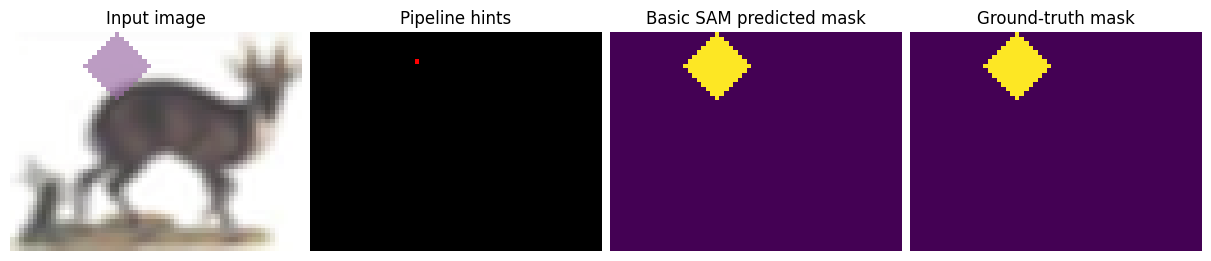

Score: 1.0
Distance: 5.728154182434082
IoU: 1.0


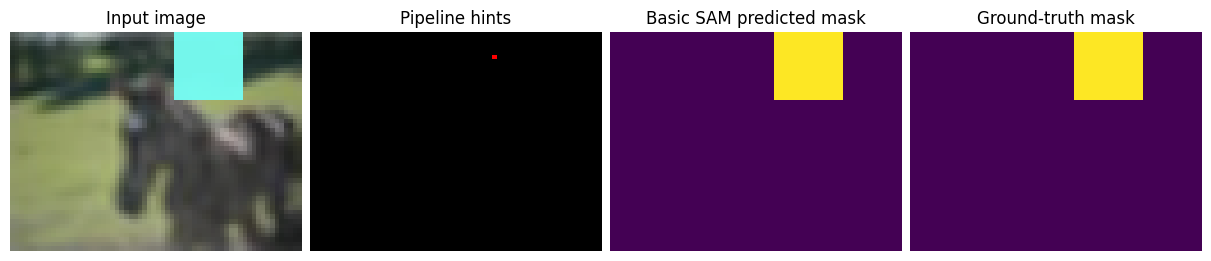

Score: 1.0
Distance: 5.280317306518555
IoU: 1.0


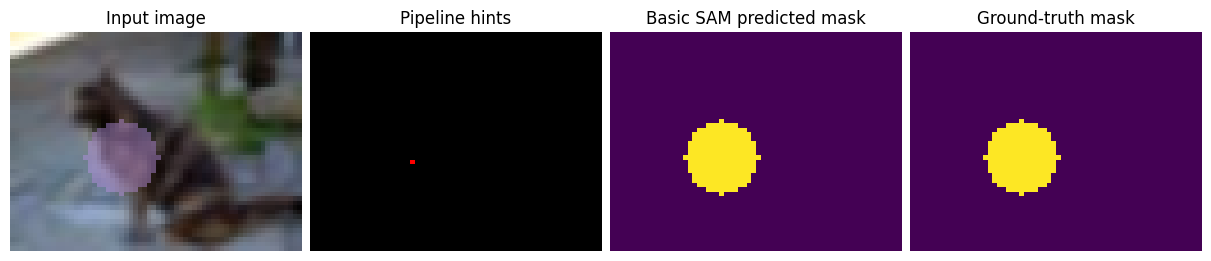

In [32]:
visual_test(pipeline=pipeline)

In [33]:
pipeline_test(pipeline)

Batch 1 | IoU(batch): 0.800 | Hit(batch): 0.800 | Distance(batch): 8.141
Batch 2 | IoU(batch): 0.797 | Hit(batch): 0.800 | Distance(batch): 7.220
Batch 3 | IoU(batch): 0.993 | Hit(batch): 1.000 | Distance(batch): 4.486
Batch 4 | IoU(batch): 0.420 | Hit(batch): 0.423 | Distance(batch): 16.950
Batch 5 | IoU(batch): 0.607 | Hit(batch): 0.613 | Distance(batch): 12.220
Batch 6 | IoU(batch): 0.798 | Hit(batch): 0.800 | Distance(batch): 9.500
Batch 7 | IoU(batch): 0.597 | Hit(batch): 0.597 | Distance(batch): 14.103
Batch 8 | IoU(batch): 0.600 | Hit(batch): 0.600 | Distance(batch): 14.087
Batch 9 | IoU(batch): 0.600 | Hit(batch): 0.600 | Distance(batch): 12.586
Batch 10 | IoU(batch): 1.000 | Hit(batch): 1.000 | Distance(batch): 4.847
Batch 11 | IoU(batch): 0.996 | Hit(batch): 1.000 | Distance(batch): 4.674
Batch 12 | IoU(batch): 0.779 | Hit(batch): 0.800 | Distance(batch): 11.854
Batch 13 | IoU(batch): 0.600 | Hit(batch): 0.600 | Distance(batch): 10.986
Batch 14 | IoU(batch): 0.605 | Hit(batch

**BackgroundAndForegroundSamPipeline**:
1. Uses Grad-CAM heatmaps to select the most salient foreground pixels
2. Apply `heatmap_transform` to smooth and expand activations
3. Computes the center of foreground points.
4. Samples background points sufficiently far from the foreground center.
5. Combines both into point coordinates and labels compatible with SAM.



In [34]:
import numpy as np
import torch
from torch import nn, Tensor
from typing import Tuple
from typing_extensions import override


class BothSamPipeline(CustomPipeline):
    """
    Pipeline that combines Grad-CAM–based foreground point selection
    with random background point sampling for SAM-style segmentation.

    The pipeline:
    1. Uses Grad-CAM heatmaps to select the most salient foreground pixels.
    2. Apply `heatmap_transform` to smooth and expand activations.
    3. Computes the center of foreground points.
    4. Samples background points sufficiently far from the foreground center.
    5. Combines both into point coordinates and labels compatible with SAM.

    Foreground points are labeled as `1`, background points as `0`.
    """

    def __init__(
        self,
        model: nn.Module,
        grad_cam: GradCAM,
        num_for_pixels: int = 20,
        num_back_pixels: int = 100,
        min_distance: float = 50,
    ):
        """
        Initialize the pipeline.

        Args:
            model (nn.Module):
                Segmentation model used by the base `CustomPipeline`.
            grad_cam (GradCAM):
                Grad-CAM object used to compute saliency heatmaps.
            num_for_pixels (int, optional):
                Number of foreground (positive) points per image.
            num_back_pixels (int, optional):
                Number of background (negative) points per image.
            min_distance (float, optional):
                Minimum Euclidean distance (in pixels) between background
                points and the foreground center.
        """
        self.model = model
        self.grad_cam = grad_cam
        self.num_for_pixels = num_for_pixels
        self.num_back_pixels = num_back_pixels
        self.min_distance = min_distance

    @override
    def points(self, images: Tensor) -> Tuple[np.ndarray, np.ndarray]:
        """
        Generate foreground and background point prompts for SAM.

        Args:
            images (Tensor):
                Input images of shape (B, C, H, W) or (C, H, W).

        Returns:
            Tuple[np.ndarray, np.ndarray]:
                - point_coords: array of shape (B, N, 2) with (x, y) pixel coordinates
                - point_labels: array of shape (B, N) with labels
                  (1 = foreground, 0 = background)
        """

        # Ensure batch dimension exists
        if images.dim() == 3:
            images = images.unsqueeze(0)

        B, C, H, W = images.shape

        # Compute Grad-CAM heatmaps for each image
        heatmaps = self.grad_cam(images)

        # Convert heatmaps to numpy if needed
        if isinstance(heatmaps, torch.Tensor):
            heatmaps = heatmaps.cpu().numpy()

        # =====================
        #  FOREGROUND POINTS
        # =====================
        foreground_pixels = []
        centres = []

        for heatmap in heatmaps:
            # Apply any required post-processing to the heatmap
            new_heatmap = heatmap_transform(heatmap)

            # Flatten heatmap to 1D for top-K selection
            flat = new_heatmap.reshape(-1)

            # Select indices of top-K foreground activations (unsorted)
            idx = np.argpartition(flat, -self.num_for_pixels)[-self.num_for_pixels:]

            # Sort selected indices by activation value (descending)
            idx = idx[np.argsort(flat[idx])[::-1]]

            # Convert flat indices back to (x, y) coordinates
            ys = idx // W
            xs = idx % W
            coords = np.stack([xs, ys], axis=1)  # shape (K, 2)

            foreground_pixels.append(coords)

            # Compute geometric center of foreground points
            centre = coords.mean(axis=0)
            centres.append(centre)

        # Stack centers for the whole batch
        centres = np.stack(centres, axis=0)  # shape (B, 2)

        # =====================
        #  BACKGROUND POINTS
        # =====================
        background_pixels = []

        for i in range(B):
            centre = centres[i]

            # Random permutation of all pixel indices
            perm = np.random.permutation(H * W)
            ys = perm // W
            xs = perm % W
            coords = np.stack([xs, ys], axis=1)

            # Compute Euclidean distance from foreground center
            dists = np.sqrt(((coords - centre) ** 2).sum(axis=1))

            # Keep only points far enough from the foreground
            eligible = coords[dists > self.min_distance]

            # Ensure the required number of background points
            if len(eligible) < self.num_back_pixels:
                # Sample with replacement if insufficient points
                pad_idx = np.random.choice(len(eligible), self.num_back_pixels, replace=True)
                eligible = eligible[pad_idx]
            else:
                eligible = eligible[:self.num_back_pixels]

            background_pixels.append(eligible)

        # =====================
        #  COMBINE INTO SAM INPUT
        # =====================
        total_points = self.num_for_pixels + self.num_back_pixels

        # Allocate arrays for SAM-compatible inputs
        point_coords = np.zeros((B, total_points, 2), dtype=np.int64)
        point_labels = np.zeros((B, total_points), dtype=np.int64)

        for i, (f_coords, b_coords) in enumerate(zip(foreground_pixels, background_pixels)):
            # Foreground points (label = 1)
            point_coords[i, :self.num_for_pixels] = f_coords
            point_labels[i, :self.num_for_pixels] = 1

            # Background points (label = 0)
            point_coords[i, self.num_for_pixels:] = b_coords
            point_labels[i, self.num_for_pixels:] = 0

        return point_coords, point_labels

    @override
    def __call__(self, images: Tensor) -> Tensor:
        """
        Run the full segmentation pipeline.

        Args:
            images (Tensor):
                Input images of shape (B, C, H, W).

        Returns:
            Tensor:
                Segmentation output produced by the base `segment` method.
        """
        point_coords, point_labels = self.points(images)
        return self.segment(images, point_coords, point_labels)


In [35]:
if type(model).__name__ == "ResNet":
    target_layers = [model.layer2[-1]]
else:
    target_layers = [
        model.get_submodule("features.2.0"),
        model.get_submodule("features.3.0"),
        model.get_submodule("features.4.0"),
    ]
grad_cam = GradCAM(model=model, target_layers=target_layers)

num_for_pixels = 1
num_back_pixels = 1
min_distance = 20


pipeline = BothSamPipeline(model=model, grad_cam=grad_cam, num_back_pixels=num_back_pixels, num_for_pixels=num_for_pixels, min_distance=min_distance)

Score: 1.0
Distance: 4.064334869384766
IoU: 1.0


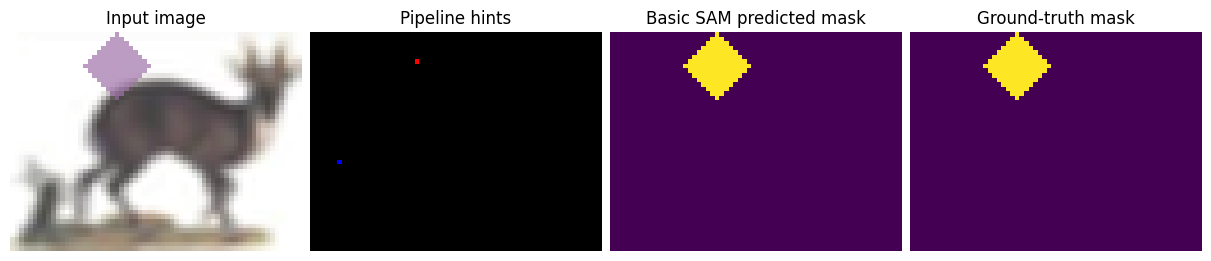

Score: 1.0
Distance: 5.728154182434082
IoU: 1.0


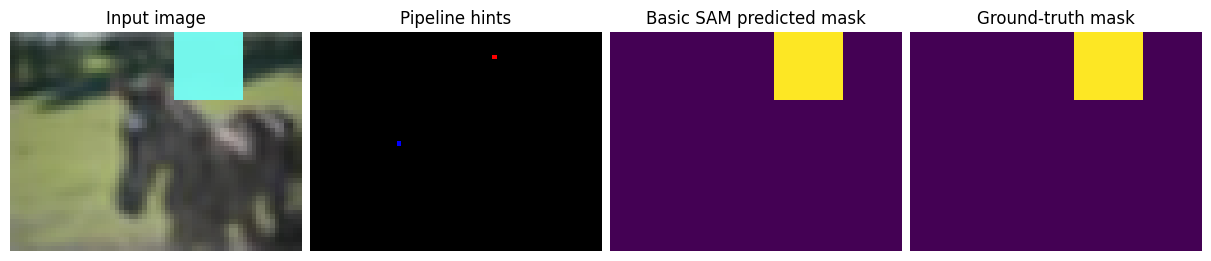

Score: 1.0
Distance: 5.280317306518555
IoU: 1.0


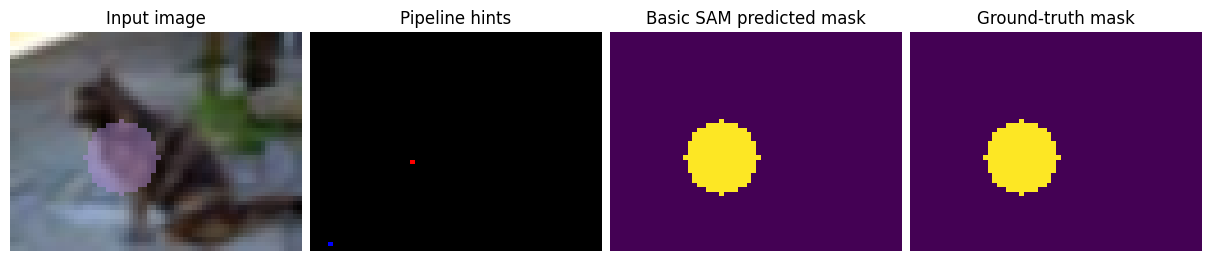

In [36]:
visual_test(pipeline=pipeline)

In [37]:
pipeline_test(pipeline)

Batch 1 | IoU(batch): 0.807 | Hit(batch): 0.807 | Distance(batch): 7.883
Batch 2 | IoU(batch): 0.796 | Hit(batch): 0.800 | Distance(batch): 7.589
Batch 3 | IoU(batch): 0.993 | Hit(batch): 1.000 | Distance(batch): 4.486
Batch 4 | IoU(batch): 0.434 | Hit(batch): 0.435 | Distance(batch): 17.332
Batch 5 | IoU(batch): 0.611 | Hit(batch): 0.613 | Distance(batch): 12.274
Batch 6 | IoU(batch): 0.791 | Hit(batch): 0.793 | Distance(batch): 10.284
Batch 7 | IoU(batch): 0.591 | Hit(batch): 0.591 | Distance(batch): 12.833
Batch 8 | IoU(batch): 0.600 | Hit(batch): 0.600 | Distance(batch): 13.267
Batch 9 | IoU(batch): 0.600 | Hit(batch): 0.600 | Distance(batch): 12.977
Batch 10 | IoU(batch): 1.000 | Hit(batch): 1.000 | Distance(batch): 4.847
Batch 11 | IoU(batch): 0.998 | Hit(batch): 1.000 | Distance(batch): 4.679
Batch 12 | IoU(batch): 0.777 | Hit(batch): 0.800 | Distance(batch): 11.846
Batch 13 | IoU(batch): 0.600 | Hit(batch): 0.600 | Distance(batch): 10.933
Batch 14 | IoU(batch): 0.606 | Hit(batc